# <center>AI2100: Assignment 2</center>
<center>Pranav K Nayak</center>  
<center>ES20BTECH11035</center>

In [2]:
import numpy as np
from PIL import Image
import typing
import warnings
import torch
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

***
## Problem 1:



The padding function creates a zero array of the required dimensions and inserts the existing array in the middle

In [3]:
def pad(image: np.ndarray, padding: int):
    padded_image = np.zeros((image.shape[0] + 2 * padding, image.shape[1] + 2 * padding, image.shape[2]))
    padded_image[padding:-padding, padding:-padding, :] = image
    return padded_image

The following non-linear activation function signatures can be passed as arguments during different stages of the execution of the CNN

In [4]:
def sigmoid(z: np.ndarray, alpha: np.ndarray):
    return 1/(1 + np.exp(-z))

def tanh(z: np.ndarray, alpha: np.ndarray):
    return np.tanh(z)

def relu(z: np.ndarray, alpha: np.ndarray):
    return np.maximum(0, z)

# PReLU assumes that the passed ndarray 'z' and the parameter ndarray 'alpha' are broadcastable
def prelu(z: np.ndarray, alpha: np.ndarray):  
    return np.maximum(0, z) + np.multiply(alpha, np.minimum(0, z))


def linear(z: np.ndarray, alpha: np.ndarray):   
    return z


def softmax(z: np.ndarray, alpha: np.ndarray):
    return np.exp(z) / np.exp(z).sum()

The convolution simply steps through the outer image, slicing out the relevant subsection of it and taking its Hadamard product with the kernel before summing it all up to the single pixel value at that location

In [5]:
def convolve(image: np.ndarray, kernel: np.ndarray, stride: int, padding: int, nl: callable, nl_parameter: np.ndarray):
  
  # number of channels is the third axis for both image and kernel
  
  if kernel.ndim == 3 and image.shape[2] != kernel.shape[2]:
    print("Kernel volume not compatible with number of image channels")
    return

  # pads the image with zeros
  if padding != 0:
    image = pad(image=image, padding=padding)

  w = image.shape[0]
  h = image.shape[1]
  c = image.shape[2]
  k = kernel.shape[0]

  final_img = np.zeros((int((w - k)/stride) + 1, int((h - k)/stride) + 1))
  
  for i in range(0, w - k + 1, stride):
    for j in range(0, h - k + 1, stride):
      final_img[i, j] = np.sum(np.multiply(image[i:i+k, j:j+k, :], kernel))

  final_img = nl(final_img, nl_parameter)

  return final_img


The test case given below is one commonly used to test for the Sobel Filter during edge detection

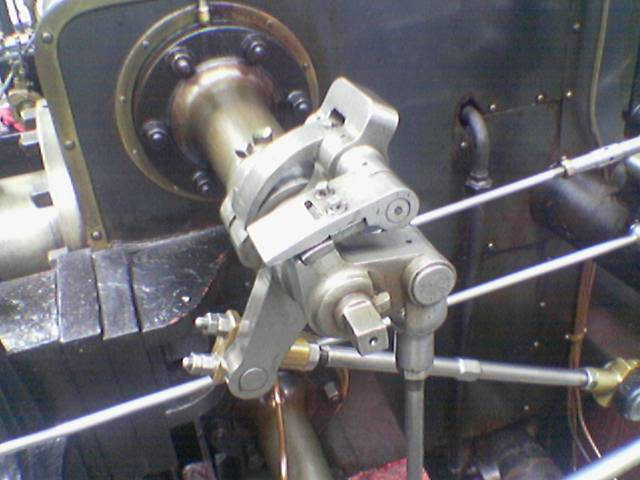

In [6]:
test_image = Image.open('edges.png')
display(test_image)


The test kernel given below is used for blurring, and the kernel is normalized to prevent large swathes of pixel values from appearing white. It tests for a stride of 1 and a padding of 10 on either side of the image, which should appear as a blurry black boundary in the final convolved output

In [7]:
test_kernel = np.ones((5, 5, 3))
test_kernel = test_kernel / np.sum(test_kernel) # For normalizing, to make sure pixel values don't exceed 255

In [8]:
test_image = np.asarray(test_image)
print(test_image.shape)
test_result = convolve(image=test_image, kernel=test_kernel, stride=1, padding=10, nl=linear, nl_parameter=0)

(480, 640, 3)


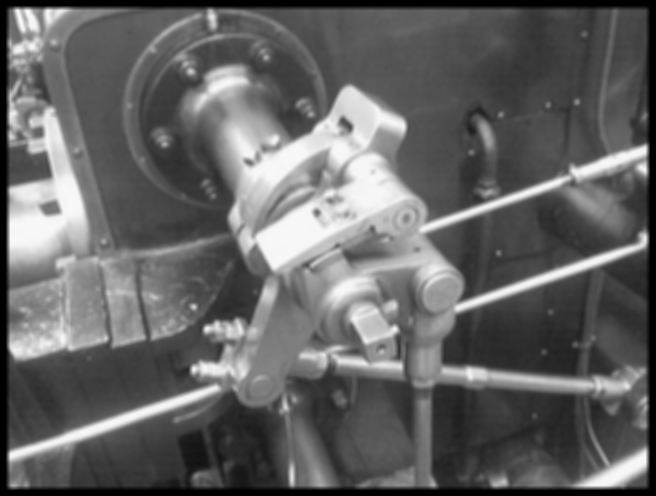

(496, 656)


In [9]:
image_result = Image.fromarray(test_result)

if image_result.mode != 'RGB':
    image_result = image_result.convert('RGB')
  

display(image_result)
print(test_result.shape)

***
## Problem 2

The following types of pooling can be passed as arguments during various pooling-layer stages

In [10]:
def max_pooling(z: np.ndarray):
    return z.max()


def min_pooling(z: np.ndarray):
    return z.min


def avg_pooling(z: np.ndarray):
    return np.average(z)

The pooling function steps through the input map, assuming an identical stride in the horizontal and vertical directions, and performs the pooling on the relevant subsection of the map, using the pooled value to represent that section in the output

In [11]:
def pooling(input_map: np.ndarray, stride: int, pool: callable):
    w = input_map.shape[0]
    h = input_map.shape[1]

    output_map = np.zeros((int(w/stride), int(h/stride)))
    
    for i in range(0, w - stride, stride):
        for j in range(0, h - stride, stride):
            output_map[int(i/stride), int(j/stride)] = pool(input_map[i: min(w, i + stride), j: min(h, j + stride)])
    
    return output_map

The following test case tests for Max Pooling, with a stride of 2, i.e. a pooling window of 2x2, taking as input the output from the convolution function of the previous section

In [12]:
pooling_test_result = pooling(input_map=test_result, stride = 2, pool=max_pooling)
print(pooling_test_result.shape)

(248, 328)


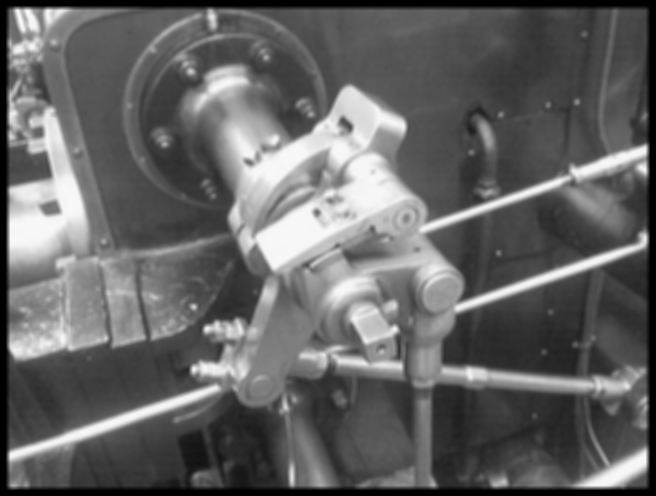

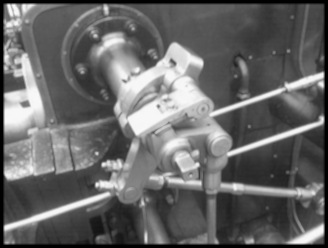

In [13]:
pooling_image_result = Image.fromarray(pooling_test_result)

if pooling_image_result.mode != 'RGB':
    pooling_image_result = pooling_image_result.convert('RGB')

display(image_result)
display(pooling_image_result)

*** 
## Problem 3

The convolution layer function has two separate cases, one where the first argument passed is a list, in which case it is an input map, and one where the first argument is a NumPy array, in which case it is an image.  
In the first case, all kernels are randomly regenerated to contain the same number of channels as there are 2D input maps in the list. In the second, it assumes the kernels are passed as 3D ones to be applicable to the 3-channel image.

In [14]:
def convolution_layer(image: np.ndarray, nb_filters: int, kernel_dims: typing.List[typing.Tuple[int, int]], stride: int, padding: int, nl: int, nl_param: np.ndarray):
    filters = [np.random.randn(k_r, k_c, k_ch) for (k_r, k_c, k_ch) in kernel_dims]
    filters = [i/np.sum(i) for i in filters]
    if isinstance(image, list):
        image = np.array(image)
        image = np.moveaxis(image, 0, -1)
        filters = [np.random.randn(k_r, k_c, image.shape[2]) for k_r, k_c, k_ch in kernel_dims]
        # filters = [i/np.sum(i) for i in filters]  # Optional, use when too many white pixels show up in the output images

    conv_volume = [convolve(image=image, kernel=kernel, stride=stride, padding=padding, nl=nl, nl_parameter=nl_param) for kernel in filters]
    #conv_volume = np.moveaxis(np.array(conv_volume), 0, -1)

    return conv_volume


The function assumes that the kernel volume matches the image channels for the second case, and if this is not followed, could result in an error if the shapes passed are not broadcastable

The test case below is used to demonstrate the generation of multiple different output maps of different dimensions from a single image.

In [15]:
kernel_dims_test = [(2,2,3), (3,3,3), (4,4,3), (5,5,3)]
conv_volume = convolution_layer(image=test_image, nb_filters=len(kernel_dims_test), kernel_dims=kernel_dims_test, stride=1, padding=0, nl=linear, nl_param=0)

[(479, 639), (478, 638), (477, 637), (476, 636)]


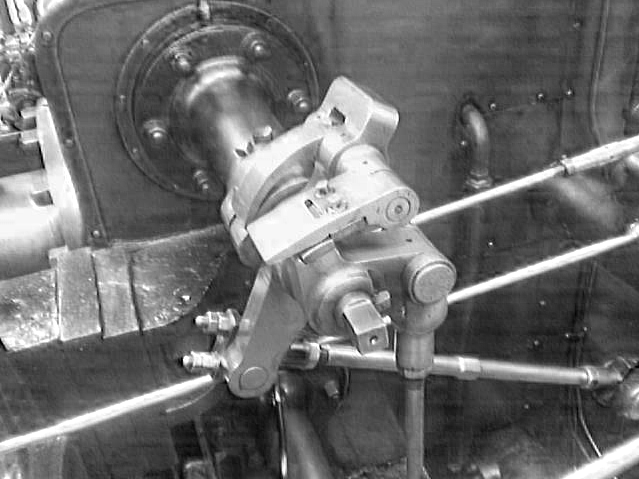

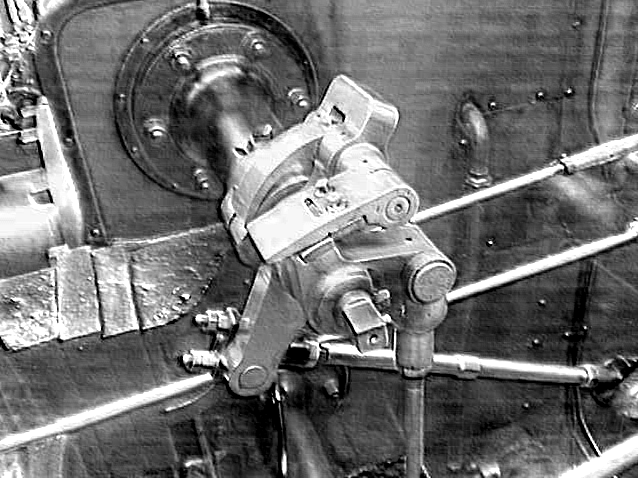

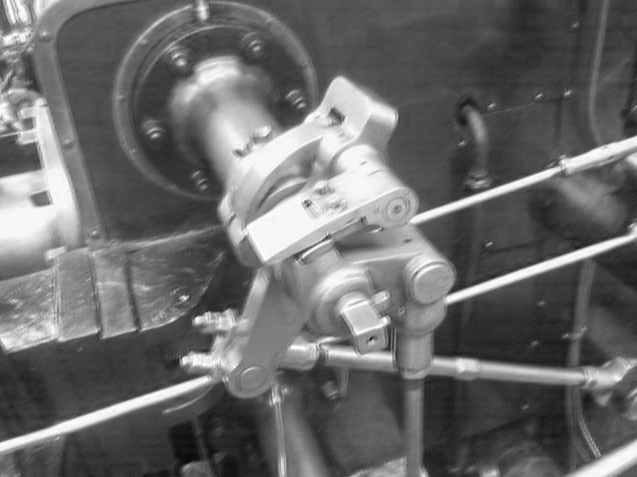

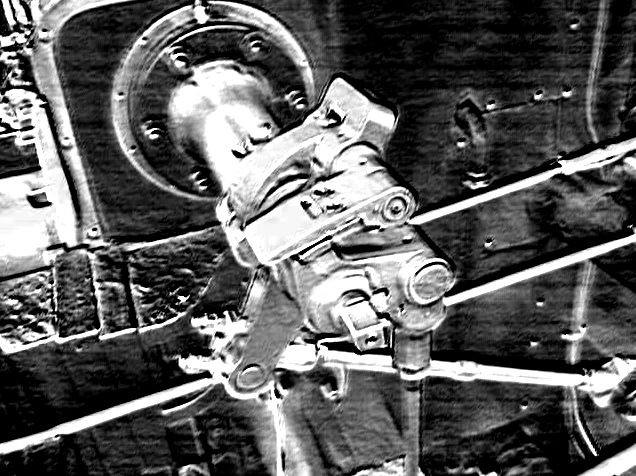

In [16]:
print([i.shape for i in conv_volume])

image_list = [Image.fromarray(x) for x in conv_volume]
for x in image_list:
    x = x.convert('RGB')
    display(x)

As can be seen from the previous three cells, convolution is performed on the original image in 4 different manners, and outputs that satisfy the dimensionality equations discussed in class are generated.

***
## Problem 4

The pooling layer simply performs the given pooling function for a list of input activation maps, applying the same pooling with the same stride to every map in the list. In the special case of GAP, it returns a one-dimensional NumPy array.

In [17]:
def pooling_layer(input_map_volume: typing.List[np.ndarray], pool: callable, stride: int, global_average=False):
    if not global_average:
        pooled_volume = [pooling(input_map=i, stride=stride, pool=pool) for i in input_map_volume]
        return pooled_volume
    else:
        pooled_volume = [np.average(i) for i in input_map_volume]
        return pooled_volume


The test cases below demonstrate max pooling on multiple different input activation maps, displaying the images before and after pooling and showing how the dimensionality constraints are preserved

In [18]:
pooled_volume = pooling_layer(input_map_volume=conv_volume, pool=max_pooling, stride=2)

[(239, 319), (239, 319), (238, 318), (238, 318)]


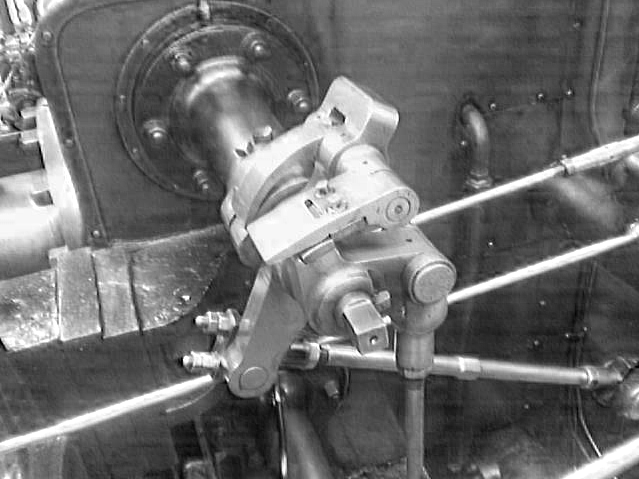

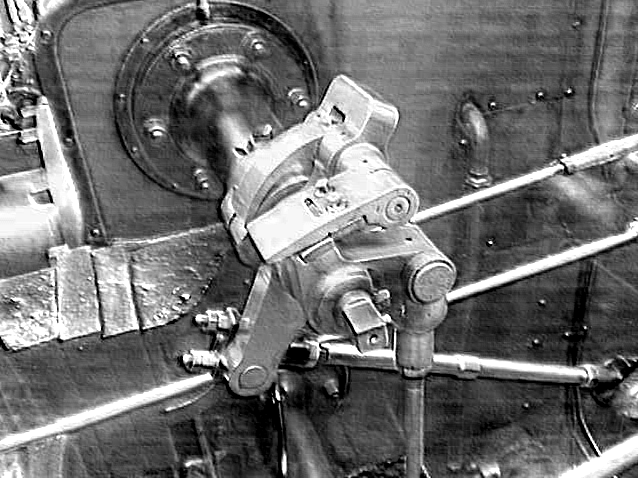

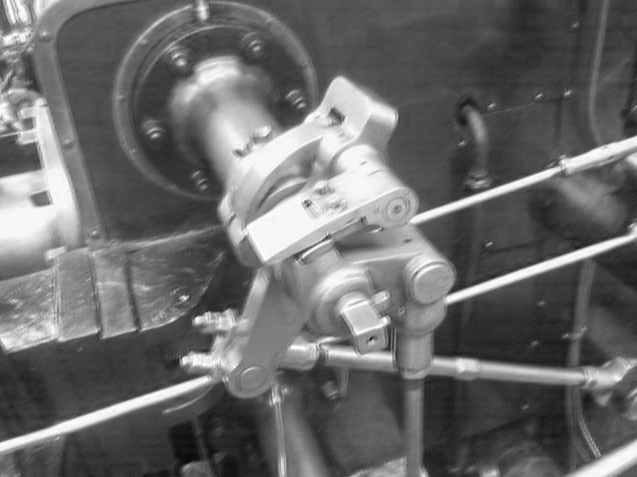

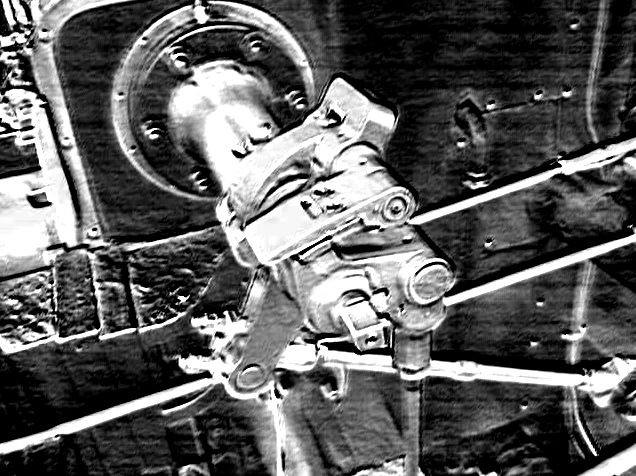

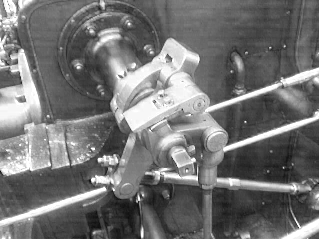

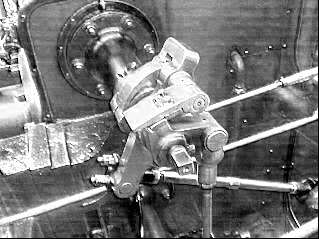

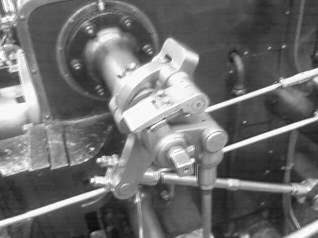

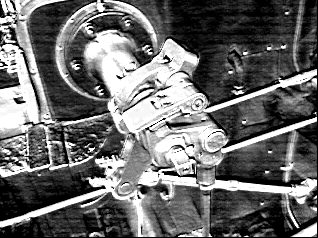

In [19]:
print([p.shape for p in pooled_volume])

image_list = [Image.fromarray(x) for x in conv_volume]
for x in image_list:
    x = x.convert('RGB')
    display(x)

pooled_image_list = [Image.fromarray(x) for x in pooled_volume]
for x in pooled_image_list:
    x = x.convert('RGB')
    display(x)

***
## Problem 5


The flatten function first straightens out the list of activation maps given as input, before multiplying it with a randomly generated reduction matrix to result in a column vector of the required length, specified as input

In [20]:
def flatten(input_volume: typing.List[np.ndarray], output_size: int):
    output_layer = np.concatenate(tuple([i for i in input_volume]), axis=None)
    reduction_matrix = np.random.randn(output_size, output_layer.shape[0])
    output_layer = np.matmul(reduction_matrix, output_layer)
    return output_layer.reshape((output_layer.shape[0], 1))

The test case takes the activation maps from the previous Max Pooling layer and flattens them out into roughly 300,000 values, before compressing them into a 50-length vector

In [21]:
layer = flatten(input_volume=pooled_volume, output_size=50)
print(layer.shape)

(50, 1)


***
## Problem 6

The MLP function takes as input the input layer values, the number and dimensions of the hidden layers, and the dimension of the output layer. It randomly generates the bias vectors and weight matrices for each layer and layer-to-layer transition, and applies the MLP feedforward formula to the input layer activations. It returns the output layer activations, as well as their softmaxed values, as a tuple.

In [22]:
def mlp(input_layer: np.ndarray, nb_hidden_layers: int, hidden_layers: typing.List[int], nl: callable, nl_param: np.ndarray, output_size: int):
    if input_layer.ndim == 1:
        input_layer = input_layer.reshape(input_layer.shape[0], 1)
    nb_layers = 2 + len(hidden_layers)
    sizes = [input_layer.shape[0]]
    sizes += hidden_layers
    sizes.append(output_size)

    biases = [np.random.randn(y, 1) for y in sizes[1:]]
    weights = [np.random.randn(y, x) for x,y in list(zip(sizes[:-1], sizes[1:]))]

    activations = [] # For storage, in case learning needs to be performed

    output_layer = input_layer
    for bias, weight in list(zip(biases, weights)):
        linear_input = np.dot(weight, output_layer) + bias
        output_layer = nl(linear_input, nl_param)
    
    return output_layer, softmax(output_layer, alpha=0)

The test case creates a network of size [50, 100, 50, 20, 10], and performs the feedforward on it, taking as input the output of the previous flattening test case from Problem 5

In [23]:
test_hidden_layers = [100, 50, 20]
mlp_output, mlp_softmax_output = mlp(input_layer=layer, nb_hidden_layers=3, hidden_layers=test_hidden_layers, nl=sigmoid, nl_param=0, output_size=10)

***
## Problem 7
 

The feedforward function explicitly outlines the various convolution layers and pooling layers as specified in the question, taking as input into the current layer the output of the previous layer. It ends by performing an MLP forward pass, returning the MLP's output as well as its softmaxed value.

In [24]:
def cnn_feedforward(image: np.ndarray):
    conv_layer1 = convolution_layer(image=image, nb_filters=16, kernel_dims=[(3, 3, 3)] * 16, stride=1, padding=0, nl=sigmoid, nl_param=0)
    pooled_layer1 = pooling_layer(input_map_volume=conv_layer1, pool=max_pooling, stride=2)
    conv_layer2 = convolution_layer(pooled_layer1, nb_filters=8, kernel_dims=[(3, 3, 1)] * 8, stride=1, padding=0, nl=sigmoid, nl_param=0)
    pooled_layer2 = pooling_layer(input_map_volume=conv_layer2, pool=max_pooling, stride=2)
    pooled_layer3 = pooling_layer(input_map_volume=pooled_layer2, pool=max_pooling, stride=1, global_average=True)
    mlp_output_layer, softmax_layer = mlp(input_layer=np.array(pooled_layer3), nb_hidden_layers=1, hidden_layers=[len(pooled_layer3)], nl=sigmoid, nl_param=0, output_size=10)

    return mlp_output_layer, softmax_layer

The cells below deal with extracting the CIFAR images from the tarball. It assumes that the tarball itself has been decompressed and is present in the same directory as this notebook in the directory 'cifar-10-batches-py/'

In [25]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [26]:
def extract_image(i):
  batch = unpickle('cifar-10-python/cifar-10-batches-py/data_batch_1')
  data = batch[b'data']
  red_channel = data[i, :1024].reshape(32, 32, 1)
  green_channel = data[i, 1024:2048].reshape(32, 32, 1)
  blue_channel = data[i, 2048:3072].reshape(32, 32, 1)

  cifar_image = np.concatenate((red_channel, green_channel, blue_channel), axis=2)
  return cifar_image

cifar_image = extract_image(0)

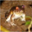

In [27]:
image_render = Image.fromarray(cifar_image, 'RGB')


display(image_render)

The test case below performs the CNN's forward pass on the first image in the dataset

In [28]:
test_output, sm_output = cnn_feedforward(image=cifar_image.astype(np.float64))

In [29]:
print(test_output.shape)
print(sm_output.shape)

(10, 1)
(10, 1)


As can be seen, the function takes a 3-channel, 2D image as input and outputs a vector

***
## Problem 8


In [30]:

# 8a
batch = unpickle('cifar-10-python/cifar-10-batches-py/data_batch_2')
data = batch[b'data']

images = []

for i in range(data.shape[0]):
    red_channel = data[i, :1024].reshape(32, 32, 1)
    green_channel = data[i, 1024:2048].reshape(32, 32, 1)
    blue_channel = data[i, 2048:3072].reshape(32, 32, 1)

    images.append(np.concatenate((red_channel, green_channel, blue_channel), axis=2))

labels = batch[b'labels']


found_labels = []
valid_images = []
i = 0
while len(found_labels) != 10:
    if labels[i] not in found_labels:
        valid_images.append(images[i])
        found_labels.append(labels[i])
    i += 1


In [31]:
found_labels.sort()
print(found_labels)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [32]:
output_vectors = [cnn_feedforward(i.astype(np.float64))[1] for i in valid_images]

In [33]:
for i in output_vectors:
    print(i)

[[0.0848017 ]
 [0.14427702]
 [0.05894748]
 [0.11853834]
 [0.11711156]
 [0.07093157]
 [0.0938107 ]
 [0.12863729]
 [0.05843254]
 [0.12451178]]
[[0.08821576]
 [0.07068222]
 [0.13057012]
 [0.10703873]
 [0.10725618]
 [0.13574032]
 [0.0845414 ]
 [0.0705494 ]
 [0.13622682]
 [0.06917905]]
[[0.05892344]
 [0.08480088]
 [0.07728929]
 [0.12161269]
 [0.07445887]
 [0.15209984]
 [0.15138094]
 [0.08590274]
 [0.0776146 ]
 [0.11591671]]
[[0.06872328]
 [0.09601931]
 [0.0622913 ]
 [0.07124181]
 [0.12938626]
 [0.06246236]
 [0.12825673]
 [0.12251288]
 [0.12845425]
 [0.13065182]]
[[0.08383454]
 [0.07824099]
 [0.11912202]
 [0.14855024]
 [0.08004542]
 [0.06889487]
 [0.06256422]
 [0.14969593]
 [0.13221204]
 [0.07683974]]
[[0.13892993]
 [0.08463331]
 [0.09017488]
 [0.05835524]
 [0.1149646 ]
 [0.1331549 ]
 [0.07883757]
 [0.11250285]
 [0.06589527]
 [0.12255144]]
[[0.0893716 ]
 [0.11526756]
 [0.14912848]
 [0.09283335]
 [0.119451  ]
 [0.13752392]
 [0.0815642 ]
 [0.06772415]
 [0.0700325 ]
 [0.07710324]]
[[0.12757112]

As can be verified from the above output, there is no obvious observable trend in the output of the cnn for the 10 images. This makes sense, since a completely random initialization of our parameters is extremely unlikely to perform any sort  of meaningful classification


In [34]:
# 8b
found_labels2 = []
valid_images2 = []
i = 0
while(len(found_labels2) != 30):
    if labels[i] not in found_labels2 or found_labels2.count(labels[i]) < 3:
        found_labels2.append(labels[i])
        valid_images2.append(images[i])
    i += 1


In [35]:
print(len(valid_images2))

30


In [36]:
cnn_outputs = [torch.Tensor(cnn_feedforward(i)) for i in valid_images2]